<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/Training_and_Deploying_at_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import json
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt

Checking GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    print("Disabling virtual GPU configuration...")
    tf.config.experimental.set_visible_devices([], 'GPU') # Disable virtual devices
    physical_gpus = tf.config.experimental.list_physical_devices('GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"Physical GPUs: {len(physical_gpus)}, Logical GPUs: {len(logical_gpus)}")
  except RuntimeError as e:
    print("Error:", e)
else:
    print("No GPU found.")


Disabling virtual GPU configuration...
Physical GPUs: 1, Logical GPUs: 0


Data Preparation

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full[..., np.newaxis].astype(np.float32) / 255.
X_test = X_test[..., np.newaxis].astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Build and Training Base Model

In [4]:
with tf.device('/CPU:0'):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(learning_rate=1e-2),
                  metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7054 - loss: 1.1003 - val_accuracy: 0.8986 - val_loss: 0.3721
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8992 - loss: 0.3684 - val_accuracy: 0.9166 - val_loss: 0.3041
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9129 - loss: 0.3095 - val_accuracy: 0.9236 - val_loss: 0.2679
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9221 - loss: 0.2803 - val_accuracy: 0.9300 - val_loss: 0.2477
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9298 - loss: 0.2553 - val_accuracy: 0.9336 - val_loss: 0.2287


Save Model

In [5]:
model_name = "my_mnist_model"
model_version = "0001"
model_dir = os.path.join("/content/", model_name, model_version)
print(f"\nMenyimpan model ke direktori: {model_dir}")
model.export(model_dir)

print("\nStruktur direktori SavedModel:")
!ls -lR {os.path.join("/content/", model_name)}


Menyimpan model ke direktori: /content/my_mnist_model/0001
Saved artifact at '/content/my_mnist_model/0001'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140417931749008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140417931749968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140417931749392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140417931749776: TensorSpec(shape=(), dtype=tf.resource, name=None)

Struktur direktori SavedModel:
/content/my_mnist_model:
total 4
drwxr-xr-x 4 root root 4096 Jun 17 15:04 0001

/content/my_mnist_model/0001:
total 48
drwxr-xr-x 2 root root  4096 Jun 17 15:04 assets
-rw-r--r-- 1 root root    58 Jun 17 15:04 fingerprint.pb
-rw-r--r-- 1 root root 33571 Jun 17 15:04 saved_model.pb
drwxr-xr-x 2 root root  4096 Jun 17 15:04 variables

TensorFlow Serving

In [6]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update
!apt-get install tensorflow-model-server


deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   7758      0 --:--:-- --:--:-- --:--:--  7744
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [79.8 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,778 kB]
Get:5 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:6

In [7]:
os.environ["MODEL_DIR"] = os.path.join("/content/", model_name)

In [8]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=my_mnist_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [9]:
print("\nServer TF Serving sedang dimulai di background...")
time.sleep(5)


Server TF Serving sedang dimulai di background...


In [10]:

X_new = X_test[:3]
request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist()
})
SERVER_URL = "http://localhost:8501/v1/models/my_mnist_model:predict"


Query berhasil!
Prediksi dari server: [7 2 1]
Label sebenarnya:   [7 2 1]


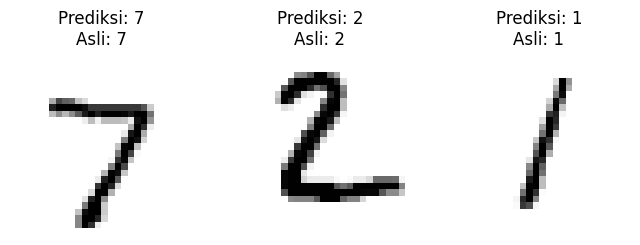

In [11]:
try:
    response = requests.post(SERVER_URL, data=request_json)
    response.raise_for_status()
    response_data = response.json()

    print("Query berhasil!")
    y_proba = np.array(response_data["predictions"])
    y_pred = np.argmax(y_proba, axis=1)

    print(f"Prediksi dari server: {y_pred}")
    print(f"Label sebenarnya:   {y_test[:3]}")

    plt.figure(figsize=(8, 4))
    for index, image in enumerate(X_new):
        plt.subplot(1, 3, index + 1)
        plt.imshow(image.squeeze(), cmap="binary")
        plt.title(f"Prediksi: {y_pred[index]}\nAsli: {y_test[index]}")
        plt.axis("off")
    plt.show()

except Exception as e:
    print(f"\nError saat melakukan Query: {e}")
    print("\n--- Log Server (server.log) ---")
    !cat server.log

Distribution Training with MirroredStrategy

In [12]:
distribution = tf.distribute.MirroredStrategy()
with distribution.scope():
    mirrored_model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28, 1]),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10)
    ])
    optimizer = keras.optimizers.Adam()
    loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mirrored_model.compile(loss=loss_function,optimizer=optimizer,metrics=["accuracy"])

history_dist = mirrored_model.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8686 - loss: 0.4604 - val_accuracy: 0.9618 - val_loss: 0.1507
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9609 - loss: 0.1346 - val_accuracy: 0.9694 - val_loss: 0.1038
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9730 - loss: 0.0903 - val_accuracy: 0.9728 - val_loss: 0.0911
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9812 - loss: 0.0652 - val_accuracy: 0.9742 - val_loss: 0.0871
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9851 - loss: 0.0525 - val_accuracy: 0.9758 - val_loss: 0.0760
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9873 - loss: 0.0406 - val_accuracy: 0.9790 - val_loss: 0.0733
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9915 - loss: 0.0303 - val_accuracy: 0.9766 - val_loss: 0.0701
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9927 - loss: 0.0258 

Evaluate

In [13]:
print("\nEvaluasi akhir model:")
loss, accuracy = mirrored_model.evaluate(X_test, y_test)
print(f"Loss Test: {loss:.4f}, Akurasi Test: {accuracy:.4f}")



Evaluasi akhir model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.1051
Loss Test: 0.0864, Akurasi Test: 0.9759


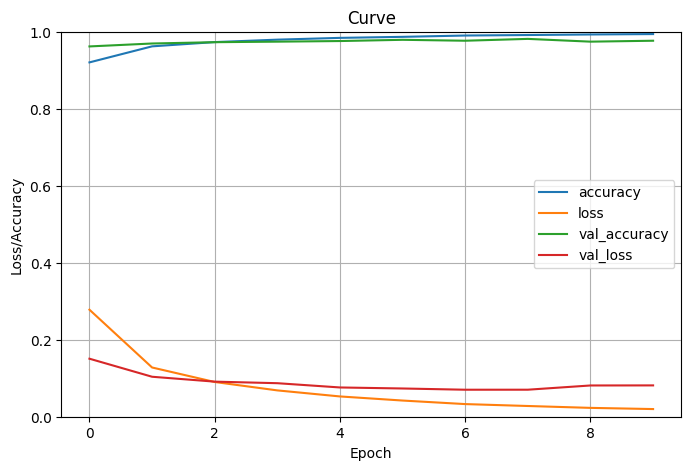

In [14]:
pd.DataFrame(history_dist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()